# Signal injection and data analysis

Author: Francesco Cipriano

In the last decades a new model for the dark matter (DM) has been proposed in which the DM is described by an ultra-light scalar field $\phi$. The spatial variations of such field is able to exert position-dependent oscillatory force on gravitational waves detectors' optical equipment. As a result, the optical equipment undergoes position-dependent oscillatory motions, which ends up with the non-vanishing signals in the GW detectors' outputs.


In the following code we simulate $nb\_sets$ data sets each of which is further salmpled $N$ times at the discrete time $t = t_j = jdt$. The data are then analysed to infer whether or not a signal is present. 

# Packages
List of the packages we are gonna need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, special, stats
from scipy.fftpack import fft, ifft
from math import floor

# Data generation

For each of the data streams, one generates a cosinusoidal signal <br>

$$
h_j = h_0\cos\left(2\pi f_0 t_j+\delta\right), \qquad j = 0, 1, ..., N-1, \qquad (1)
$$
<br>
where $h_0$ is the signal amplitude, $f_0$ its characteristc frequency and $\delta$ the unknown phase uniformly distribuited over the range $\delta \in  \left[\,0, 2\pi \, \right[$.

Cosidering the nature of the signal it is convinient to recast the problem in the Fourier domain via a Discrete Fourier Transfomr

$$
x_k = \sum_{j = 0}^{N-1} d_je^{2\pi i j k /N}, \; for \; k = -N/2+1, ..., N/2.
$$

Here and elsewhere the symbol $x$ without indices refer to the collective ensemble of all the data. We will label the frequency bins with the corresponding value of $k$. The frequencies that these bins correspond to is,

$$
f_k = \dfrac{k}{Ndt}.
$$

Beacuse the data are real one has $x_k = x^*_{-k}$. Then the data set $h_j$ is exactly equivalent to the set $x_k$ for $k = 0, ..., N/2$. One can further simplify the analysis assuming that the average value of the $h$ set vanishes and that there is no energy in the nysquit frequency $f_{N/2}$. If we do so, then $x_0 = x_{N/2} =  0$ and the initial data set $h$ becames equivalent to the set $x_k$ for $k = 1, ..., N/2-1$.

---------------------------------------------------------------------------------------------------------------------------------------------------

### Signal parameters

Also we assumed the signal frequency $f_0$ to be the resolved frequency labeled by the $l$ index<br><br>
$$
f_0 = f_l = \dfrac{l}{Ndt}.
$$

In [2]:
f_0 = 40 # s^-1
h_bar = 1.041436269208882e-23 # amplitude for f = 40.0 = x1[120*1]
dg = 0.01
h = dg*h_bar
#h = 1.041436269208882e-24 # amplitude for f = 40.0 = x1[120*1], dg=0.1
#h = 1.041436269208882e-25 # amplitude for f = 40.0 = x1[120*1], dg=0.01

### Search parameters
We simulate $nb\_sets$ time-domain data sets whose time length equals $T=Ndt=30s$.

In [3]:
dt = 0.05/f_0 # 0.00125 per omega signal = 40
T = 30 # time_single_search (s)
N = int(T/dt)
nb_sets = 500
day_SI = 24*60*60
day = T*nb_sets/day_SI
print("Total observational campaign duration: {:.3} days". format(day))

Total observational campaign duration: 0.174 days


### Noise parameters

We assume that both the real and imaginary part, $n_{k_{re}}$ and $n_{k_{im}}$,  of the noise contribution to $x_k$ to be independent and gaussian with average $\mu_{k_{re}}= \mu_{k_{im}}=0$ and variance $\sigma^2_{k_{re}}= \sigma^2_{k_{im}}=\sigma^2_k$. The probability distributions of the noise realization of each bin is then described by

\begin{equation}
\begin{split}
p\left(n_k\right)&= p\left(n_{k_{re}}\right)p\left(_{k_{im}}\right)\\
&=\dfrac{1}{\sqrt{2\pi}\sigma_k}e^{-\frac{n^2_{k_{re}}}{2\sigma_k^2}}\cdot \dfrac{1}{\sqrt{2\pi}\sigma_k}e^{-\frac{n^2_{k_{im}}}{2\sigma_k^2}}\\
&=\dfrac{1}{2\pi\sigma^2_k}e^{-\frac{n^2_{k}}{2\sigma_k^2}}.
\end{split}
\end{equation}

To be as true as possible to what would be real data the variance $\sigma^2_k$ is related to the detector one-sided noise spectral density $S_n(f_k)$ through the following equation <br>

$$
\sigma^2_k = \dfrac{N}{4dt}S_n(f_k).
$$

In [4]:
wkf='LHO3.txt' #LIGO sensitivity curves https://dcc.ligo.org/LIGO-T2000012/public
f_h3,sn_h3=np.loadtxt(wkf, usecols=(0,1),unpack=True)
temp_h3 = list(zip(f_h3, sn_h3))
step_h3 = 1 # step used to scan the values in "temp"

sn_root = sn_h3[120*1]
sigma_noise = np.sqrt(0.25*N/dt)*sn_root

### Delay

First we create a $delay$ list. The element of such a list are the time delays between the and of one data set and the beginning of the next one.
They are built in such a way that, when a delay occurs (50% in our code),  the initial phase of the following set is homogeneously distribuited between $0$ and $2\pi$ following a uniform probability distribution.

In [5]:
def rnd_phase(t):
    
    a = int(round(1/(dt*f_0), 2))
    seed = a
    
    if t == 0:
        return np.random.randint(1,seed)*dt
    
    delay = np.random.randint(2)
    if delay:
        return np.random.randint(1,seed)*dt
    else:
        return 0
    
delay = [rnd_phase(i) for i in range(nb_sets)]

### Time domain

Then one creates the $time$ list. Each element of this list is by it self a list containing the istants at which we are sampling the signal. The initial and final times of these sublists are given by
$$
t_{in} = T\cdot s + \sum_{k = 0}^{s} delay_k, \qquad t_{end} = T\cdot (s+1) + \sum_{k = 0}^{s} delay_k
$$

Here $s$ lables the different sets.  

In [6]:
time = [np.arange(np.sum(delay[:i+1])+T*i, np.sum(delay[:i+1])+T*i+T, dt ) for i in range(nb_sets)]

### Signal generation

We generate the signal evaluating equation (1) at the sampling times. Then we calculate its fourier transform.

In [7]:
signal = [1*h*np.cos(2*np.pi*f_0*time[i]) for i in range (nb_sets)]
fsignal = [fft(signal[i])[1:N//2-1] for i in range(nb_sets)]

### Noise generation

We generate the noise directly in the frequency domain.

In [8]:
def gauss(mu = 0, sigma = sigma_noise):
    return np.random.normal(mu, sigma, N//2-2)

fnoise_re = [gauss() for t in range(nb_sets)]
fnoise_im = [gauss()*1j for t in range(nb_sets)]
fnoise = [ [sum(x) for x in zip(fnoise_re[i], fnoise_im[i])] for i in range (nb_sets)]

### Data

We combine the signal and the noise to get the actual data streams.

$$
d_j  = h_j + n_j.
$$

In [9]:
fdata = [ [sum(x) for x in zip(fsignal[i], fnoise[i])] for i in range (nb_sets)]

### Example plots

We show for representative purposes the signal realization in the first data set and its fourier transform. 

In [10]:
representative_time = time[0]

#-------------------------------------------------------------------------------------------------------
fsignal_positive = fft(signal[0])[1:N//2-1]
freq = [k/T for k in range(1, N//2-1)]
fsignal_positive_power = np.abs(fsignal_positive)**2
fdata_positive_power = np.abs(fdata[0])**2

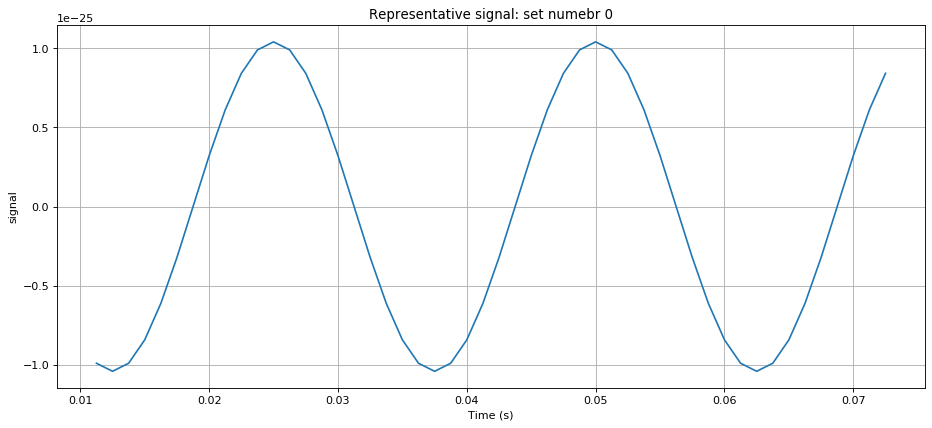

In [11]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(representative_time[:50], signal[0][:50], "-")
ax.set(xlabel='Time (s)', ylabel='signal',title='Representative signal: set numebr 0')
ax.grid()
plt.show()

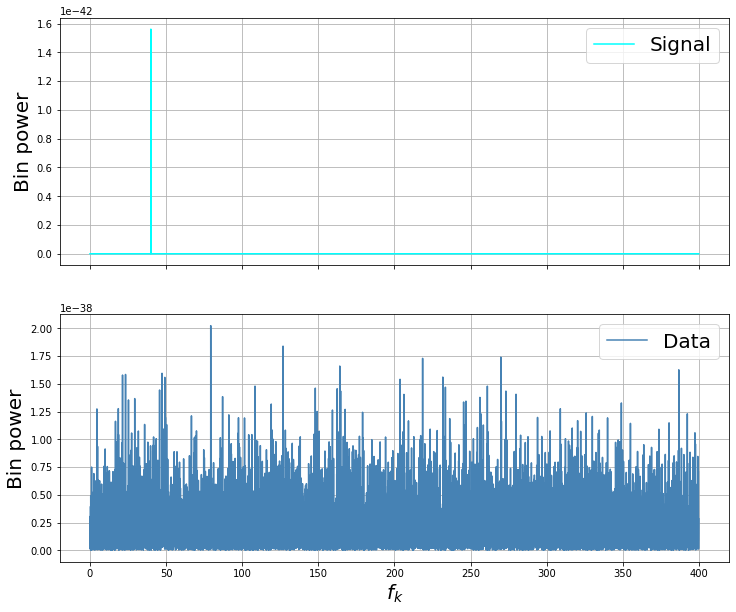

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (12, 10))

ax1.plot( freq, fsignal_positive_power, label ='Signal', color = "cyan")
ax1.grid(True)
ax1.set_xlabel(r"$f_{k}$", fontsize = 20)
ax1.set_ylabel('Bin power', fontsize = 20)
ax1.label_outer()
ax1.set_facecolor('1.0')
ax1.legend(prop={'size': 20})

ax2.plot( freq, fdata_positive_power, label ='Data', color = "steelblue")
ax2.grid(True)
ax2.set_xlabel(r"$f_{k}$", fontsize = 20)
ax2.set_ylabel('Bin power', fontsize = 20)

ax2.set_facecolor('1.0')
ax2.legend(prop={'size': 20})

plt.savefig("hidden_signal.png")

plt.show()

# Data analysis

Each of the $nb\_sets$ data sets $x$ follow the probability distribution

$$
p\left(x|h\right) = e^{-\frac{N^2}{4}\frac{h^2}{2\sigma^2_{l}}}I_{0}\left(\dfrac{Nh}{2\sigma_l}\dfrac{|x_l|}{\sigma_l}\right)\prod_{k=1}^{N/2-1}\dfrac{1}{2\pi}e^{-\frac{1}{2}|x_k|^2},
$$

with $I_0(r)$ being the modified Bessel function

$$
I_0\left(r\right) = \dfrac{1}{\pi} \int ^{\pi}_{0}d\theta e^{r\cos\theta}.
$$

In [13]:
def mod_bessel(r):
    
    def f(theta, r):
        return np.exp(r*np.cos(theta))
    
    i = integrate.quad(f, 0., np.pi, args = (r, ))
    
    return i[0]/np.pi

Now our goal is to divide the space of possible measurements $R^{N-2}$ into two disjoint regions $H_0$ and $H_1$, whose union is all of $R^{N-2}$. If the observed data lies in $H_0$, the null-hypothesis will be acepted and one will conclude that no signal was present in the data. If instead the data lies in $H_1$, one will reject the null-hypotesis and claim a detection. 
In order to opportunely choose the $H_0$ and $H_1$ regions we will follow the Neyman-Pearson criterion: the best chioce is the one tha tgives the lowest false dismissal probability for a given false alarm probability.
One defines the false alarm probability $\alpha$ as the probability that a signal is detected when none is present:

$$
\alpha = \int_{x\in H_1} dx p\left(x|0\right),
$$

whereas the false dismissal probability $\beta\left(h\right)$ describe the probability that a signal of amplitude $\epsilon$ is not found:<br>

$$
\beta\left(h\right) = \int_{x\in H_0} dx p\left(x|h\right).
$$

Once we define the likelihood function 
$$
\Gamma\left(x\right)=\dfrac{p\left(x|h\right)}{p\left(x|0\right)}= e^{-\frac{N^2}{4}\frac{h^2}{2\sigma^2_{l}}}I_{0}\left(\dfrac{Nh}{2\sigma_l}\dfrac{|x_l|}{\sigma_l}\right).
$$
<br>
We take $H_0$ as the region inside any of its level surfaces $\Lambda\left(x\right) = \Lambda_0 = constant$, and $H_1$ the region outside the same level surface.
An optimal statistic will then be any function of the observed data $x$ whose level sufaces are the same as the likelihood function. <br>
For this example we choose the power of the l'th bin

$$
\Lambda = \dfrac{|x_l|^2}{\sigma_l^2}.
$$

as our optimal statistic.<br>

In [14]:
def opt_statistic(f, l):
    sigma_squared = sigma_noise**2
    return (np.abs(f[l])**2)/sigma_squared

One can check that the mean value of this statistic is
$$
\int dx \Lambda p\left(x|\epsilon\right) = \int dx \dfrac{|x_l|^2}{\sigma_l^2} p\left(x|\epsilon\right) = 2 + \dfrac{Th^2}{S_n}.
$$

For a given threshold $\Lambda_*$, one has:
$$
H_0 = \{\left(x_1, ..., x_{N/2-1}\right) such\, that\, \Lambda = \dfrac{|x_l|^2}{\sigma_l^2}\le \Lambda_* \}
$$
$$
H_1 = \{\left(x_1, ..., x_{N/2-1}\right) such\, that\, \Lambda = \dfrac{|x_l|^2}{\sigma_l^2}\ge \Lambda_* \}.
$$

Then one can evaluate the false alarm probability

\begin{equation}
\begin{split}
\alpha\left(\Lambda_*\right)&=\int_{\frac{|x_l|^2}{\sigma_l^2}>\Lambda_*} p\left(x|0\right)dx\\
&=e^{-\Lambda_*/2}.
\end{split}
\end{equation}

In [15]:
def false_alarm_prob(lambda_star):
    return np.exp(-0.5*lambda_star)

as whell as the false dismissal probability

\begin{equation}
\begin{split}
\beta\left(\Lambda_*, h\right)&=\int_{\frac{|x_l|^2}{\sigma_l^2}\leq\Lambda_*} p\left(x|h\right)dx\\
&=e^{-\frac{N^2h^2}{8\sigma_l^2}}\int_0^{\sqrt{\Lambda_*}}u\,e^{-\frac{1}{2}u}I_0\left(\dfrac{Nh}{2\sigma_l}u\right)du,
\end{split}
\end{equation}

To help evaluating this integral we define the support constant

$$
\epsilon = \dfrac{\sqrt{T}h}{\sqrt{S_n}}.
$$

In [16]:
epsilon = np.sqrt(T)*h/sn_root

def false_dismissal_prob(threshold, ep = epsilon):
    
    
    def g(u, ep):
        r = u*np.exp(-0.5*(u**2))*mod_bessel(ep*u)
        return r
    
    i = integrate.quad(g, 0., np.sqrt(threshold), args = (ep, ))
    
    r = np.exp(-0.5*ep**2)*i[0] 
    
    return r

In absence of signal, each of the $nb\_sets$ data sets is independent. The probablity of detecting a peaks in $s$ of the $nb$ data sets is given by the binomial distribution:

$$
p\left(peaks = s\right) = \binom{n}{s}\alpha^s\left(1-\alpha\right)^{n-s}.
$$

Thus, in the absence of a signal, the mean number of peaks is $\alpha n$ and its variance is $\sigma^2 = \alpha\left(1-\alpha\right)n$. In the presence of a signal, the mean number of peaks registered is intead $\left(1-\beta\right)n$. A better way to choose the threshold $\Lambda_*$ is then to maximize the signifincance $s$<br><br><br>
$$
s = \dfrac{\left\langle \# peaks\right\rangle_{signal}-\left\langle \# peaks\right\rangle_{no signal}}{\sigma} = \dfrac{\epsilon^2}{4}\dfrac{\Lambda \sqrt{n}}{\sqrt{e^{\Lambda/2}-1}}.
$$

One can check that the maximum is obtained for 
$$\Lambda_* \simeq 3.18721$$.

In [17]:
lambda_star = 3.18721

We can now evaluate the false alarm probability, the false dismissal probability and the detection power of our analysis.<br>

In [18]:
alpha = false_alarm_prob(lambda_star)
beta = false_dismissal_prob(lambda_star)
detect_power = 1 - beta

print ("False alarm probability = {:.4}". format(alpha))
print ("False dismissal probability = {:.4}". format(beta))
print ("Detection power = {:.4}". format(detect_power))

False alarm probability = 0.2032
False dismissal probability = 0.7966
Detection power = 0.2034


We can now analyze the data. Because in this case we already know the value of $f_0$ we will check only the frequency bin it corresponds to, plus some of its neighbors. We take into account this by declaring a detection to occur only if the p-value is less than 0.05 divided by the considered frequency range.

In [19]:
def analysis(data_vec, _bin):
        power = [ opt_statistic(data_vec[i], _bin) for i in range(nb_sets) ]
        power_mean = sum(power)/nb_sets
        peaks = 0
        for i in power:
            if i > lambda_star:
                peaks = peaks +1
            
        return peaks, nb_sets-peaks, power_mean
    


def search(data_vec, _bin):
    
    
    nb_peaks, nb_not_peaks, mean = analysis(fdata, _bin)
    confidence = stats.binom_test(nb_peaks, n=nb_sets, p=alpha, alternative="greater")
    
    print("bin number {}".format(_bin))
    print("bin frequency {:.4} Hz".format((_bin+1)/T))
    print("bin power mean value: {:.4}".format(mean))
    print("number of peaks detected: {}".format(nb_peaks))
    if confidence<0.05/freq_range:
        print("p-value = {:.4}%: DETECTION.".format(confidence*100))
        print("----------------------------------------")
        
    else:
        print("p-value = {:.4}%: No detection.".format(confidence*100))
        print("----------------------------------------")
    
    return None


freq_range = 10 # must be even

for i in range(int(f_0*N*dt-1)-int(freq_range/2), int(f_0*N*dt)+int(freq_range/2)):
    search(fdata, i)

bin number 1194
bin frequency 39.83 Hz
bin power mean value: 2.064
number of peaks detected: 113
p-value = 11.37%: No detection.
----------------------------------------
bin number 1195
bin frequency 39.87 Hz
bin power mean value: 2.095
number of peaks detected: 106
p-value = 32.9%: No detection.
----------------------------------------
bin number 1196
bin frequency 39.9 Hz
bin power mean value: 1.977
number of peaks detected: 97
p-value = 71.19%: No detection.
----------------------------------------
bin number 1197
bin frequency 39.93 Hz
bin power mean value: 1.889
number of peaks detected: 95
p-value = 78.36%: No detection.
----------------------------------------
bin number 1198
bin frequency 39.97 Hz
bin power mean value: 2.11
number of peaks detected: 110
p-value = 18.91%: No detection.
----------------------------------------
bin number 1199
bin frequency 40.0 Hz
bin power mean value: 2.044
number of peaks detected: 103
p-value = 45.57%: No detection.
---------------------------

## Frequentist upper limit
In case of missed detection, we evaluate the 95% confidence level (CL) upper limit for both the injected signal amplitude $h$ and the coupling parameter $d_g^*$.
If one assumes that a signal is present in the data (in this case is not just an assumption as we know a signal is present for sure), then the probability to detect a peak for each of the $nb\_sets$ is $d=1-\beta$.
Therefore the overall numer of observed peaks follows the distribution

$$
p\left(peaks = s\right) = \binom{n}{s}d^s\left(1-d\right)^{n-s},
$$

with $n = nb\_sets$.
In order to evaluate our upper limits , the first step is to calculate the value $d_*=1-\beta_*$ such that

$$
p\left(s>s_{ob}\right) = 0.95,
$$

where $s_{ob}$ is the numer of peaks we detected during ours data analysis.
Then we evaluate the 95% CL upper limit through the equations

$$
d_g^* = \dfrac{\left(e^{\Lambda_*/2}-1-\beta_*e^{\Lambda_*/2}\right)^{1/2}}{\Lambda_*^{1/2}}\sqrt{\dfrac{4}{T}}\sqrt{\dfrac{S_{n_{l}}}{\bar{h^2}}},
$$

and 

$$
h = d_g^*\bar{h}.
$$

In [20]:
def peak_threshold_finder(alpha, nb_sets):
    peak_limit = np.floor(alpha*nb_sets)
    while(stats.binom_test(peak_limit, n=nb_sets, p=alpha, alternative="greater")>0.05/freq_range):
        peak_limit = peak_limit+1
    return peak_limit

#-----------------------------------------------

def detectiopw_finder(peak_observed, nb_sets):
    beta_limit = 0.0001
    
    while(stats.binom_test(peak_observed, n=nb_sets, p=beta_limit, alternative="greater")<0.95):
        beta_limit = beta_limit+0.0001
    return beta_limit

#-----------------------------------------------

def epsilon_fun(beta, lm = lambda_star):
    a = np.exp(0.5*lm)
    b = a-beta*a-1
    c = 4/lm
    return np.sqrt(c*b)

#-----------------------------------------------

def dg_limit_finder(epsilon):
    k = (1*sn_root)/(np.sqrt(T)*h_bar)
    return epsilon*k

In [21]:
def detection_test(data_vec, _bin):
    peak_threshold_value = peak_threshold_finder(alpha, nb_sets)
    nb_peaks_ob, nb_not_peaks_ob, mean_ob = analysis(fdata, _bin)
    
    if (nb_peaks_ob>peak_threshold_value):
        print("Number of peaks observed: {}".format(nb_peaks_ob))
        print("Number of peaks needed to claim detection: {}".format(peak_threshold_value))
        print('The injected signal has been correctly detected')
        return None
    else:
        detection_power_limit = detectiopw_finder(nb_peaks_ob, nb_sets)
        beta_threshold_value = 1-detection_power_limit
        epsilon_threshold_value = epsilon_fun(beta_threshold_value)
        dg_95CL = dg_limit_finder(epsilon_threshold_value)
        h_95CL = dg_95CL*h_bar
        print("Number of peaks observed: {}".format(nb_peaks_ob))
        print("Number of peaks needed to claim detection: {}".format(peak_threshold_value)) 
        print("95% Confindence level upper limit for h: {:.4}".format(h_95CL))
        print("95% Confindence level upper limit for dg*: {:.4}".format(dg_95CL))
        #print("Beta = {:.4}". format(beta_threshold_value))
        #print("Epsilon = {:.4}". format(epsilon_threshold_value))
        
        return None
    

detection_test(fdata, int(f_0*N*dt)-1)    

Number of peaks observed: 103
Number of peaks needed to claim detection: 126.0
95% Confindence level upper limit for h: 1.24e-24
95% Confindence level upper limit for dg*: 0.119


# Constraints plot

We tested the code by injecting a weak signal 

$$
d_g^* = 0.01 \implies h \simeq 1.04 \cdot 10^{-25}.
$$

The following plot shows how the constraints on the injected signal amplitude $h$ and on the coupling parameter $d_g^*$ improuve as we increase the duration of the observational campaign.

In [22]:
nb_sets = [100, 500, 1000, 2000] # number of data sets simulated
day_s = 24*60*60
day = [30/(day_s)*n for n in nb_sets] # observational campaign duration corresponding to the number of data sets simulated

dg_limit = [0.2541, 0.1027, 0.07667, 0.02377]
h_limit = [dg*h_bar for dg in dg_limit]

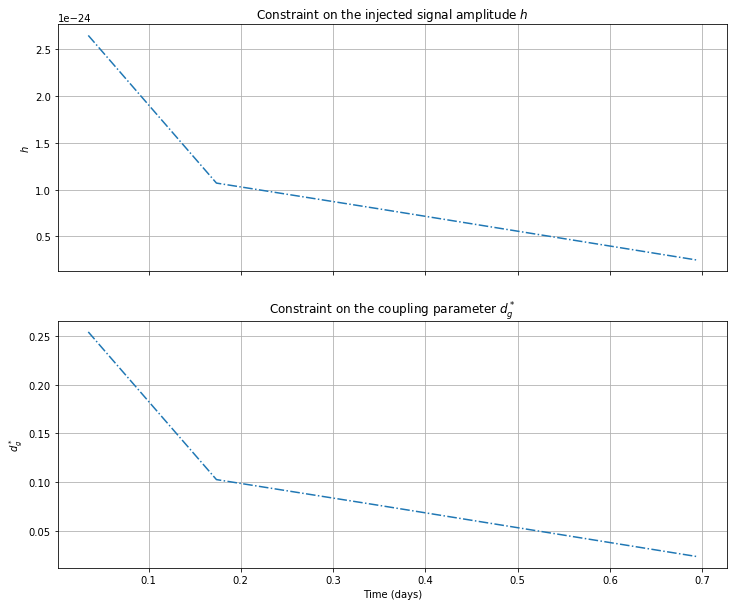

In [23]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (12, 10))

ax1.plot(day, h_limit, "-.")
ax1.set(xlabel='Time (days)', ylabel=r'$h$',title=r'Constraint on the injected signal amplitude $h$')
ax1.label_outer()
ax1.grid(True)
ax1.set_facecolor('1.0')

ax2.plot(day, dg_limit, "-.")
ax2.set(xlabel='Time (days)', ylabel=r'$d_g^*$',title=r'Constraint on the coupling parameter $d_g^*$')
ax2.grid(True)
ax2.set_facecolor('1.0')

plt.show()